<a href="https://colab.research.google.com/github/sanyarajpal13/Models/blob/main/Models_Finetuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# =============================================================================
# Demand estimation pipeline for Data-GP1
# Full EDA, feature engineering, modeling, diagnostics, and outputs
# =============================================================================

# 0) Imports
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrix
from statsmodels.iolib.summary2 import summary_col

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error

# For VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats

# Make figures prettier
sns.set(style="whitegrid", context="talk")
plt.rcParams['figure.dpi'] = 120

# Output directory
OUT = "/mnt/data/gp1_outputs"
os.makedirs(OUT, exist_ok=True)

# ---------------------------
# 1) Load and initial clean
# ---------------------------
def load_and_clean(path="Data-GP1.csv"):
    df = pd.read_csv(path)
    # Ensure known columns exist; if not, user must check CSV header
    # Convert dates
    for c in ["Dept_Date","Purchase_Date"]:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce")
    # Compute days to departure
    if "Dept_Date" in df.columns and "Purchase_Date" in df.columns:
        df["days_to_departure"] = (df["Dept_Date"] - df["Purchase_Date"]).dt.days
    else:
        df["days_to_departure"] = np.nan
    # Basic numeric conversions & safety
    if "mean_net_ticket_price" in df.columns:
        df["mean_net_ticket_price"] = pd.to_numeric(df["mean_net_ticket_price"], errors="coerce")
    if "num_seats_total" in df.columns:
        df["num_seats_total"] = pd.to_numeric(df["num_seats_total"], errors="coerce").astype("Int64")
    # Drop rows with missing core vars (we keep them but save count)
    pre_n = len(df)
    df = df.dropna(subset=["mean_net_ticket_price","num_seats_total"])
    print(f"Loaded {path}: {pre_n} rows -> {len(df)} after dropping rows without price/count.")
    return df

df = load_and_clean()

# Save cleaned snapshot
df.to_csv(os.path.join(OUT,"Data-GP1-cleaned.csv"), index=False)
print("Saved cleaned CSV to:", os.path.join(OUT,"Data-GP1-cleaned.csv"))

Loaded Data-GP1.csv: 209697 rows -> 209697 after dropping rows without price/count.
Saved cleaned CSV to: /mnt/data/gp1_outputs/Data-GP1-cleaned.csv


In [ ]:
# ---------------------------
# 2) Feature engineering (expand features to improve explanatory power)
# ---------------------------
def engineer_features(df):
    # Basic logs
    df = df.copy()
    # avoid log(0) — earlier we saw num_seats_total >=1
    df["log_price"] = np.log(df["mean_net_ticket_price"].replace(0, np.nan))
    df["log_num_seats_total"] = np.log(df["num_seats_total"].astype(float).replace(0, np.nan))
    # booking window buckets
    df["booking_window"] = pd.cut(df["days_to_departure"].fillna(-1),
                                  bins=[-1,0,3,14,60,365],
                                  labels=["missing_or_day", "last_0d", "0-3d", "4-14d","15-60d"])
    # temporal features
    if "Dept_Date" in df.columns:
        df["dept_month"] = df["Dept_Date"].dt.month
        df["dept_weekday"] = df["Dept_Date"].dt.dayofweek  # 0=Mon ... 6=Sun
        df["dept_ym"] = df["Dept_Date"].dt.to_period("M").astype(str)
    # price buckets (useful for binned plots)
    df["price_bucket"] = pd.qcut(df["mean_net_ticket_price"], 10, duplicates="drop")
    # training count per Train_Number_All (popularity measure)
    if "Train_Number_All" in df.columns:
        train_counts = df["Train_Number_All"].value_counts().to_dict()
        df["train_freq"] = df["Train_Number_All"].map(train_counts).fillna(0)
    # fill NA for binary flags if present
    for col in ["isNormCabin","isReturn","isOneway"]:
        if col in df.columns:
            df[col] = df[col].fillna(0).astype(int)
    return df

df = engineer_features(df)
print("Feature engineered. Columns now:", df.columns.tolist())

Feature engineered. Columns now: ['num_seats_total', 'mean_net_ticket_price', 'Dept_Date', 'Purchase_Date', 'Train_Number_All', 'Culmulative_sales', 'isNormCabin', 'isReturn', 'isOneway', 'Customer_Cat', 'days_to_departure', 'log_price', 'log_num_seats_total', 'booking_window', 'dept_month', 'dept_weekday', 'dept_ym', 'price_bucket', 'train_freq']


In [ ]:
# ---------------------------
# 3) Very detailed EDA (save many plots + summary tables)
# ---------------------------
def detailed_eda(df, outdir=OUT, sample_for_scatter=20000):
    # 3.1 Summary tables
    desc = df.describe(include='all').T
    desc.to_csv(os.path.join(outdir,"eda_describe.csv"))
    print("Saved descriptive stats to eda_describe.csv")

    # 3.2 Missingness
    miss = df.isnull().sum().sort_values(ascending=False)
    miss.to_csv(os.path.join(outdir,"eda_missingness.csv"))
    print("Saved missingness to eda_missingness.csv")

    # 3.3 Price distribution (log + raw)
    plt.figure(figsize=(8,4))
    sns.histplot(df["mean_net_ticket_price"].clip(upper=df["mean_net_ticket_price"].quantile(0.99)),
                 bins=80, kde=True)
    plt.title("Ticket price distribution (clipped 99th pct)")
    plt.xlabel("mean_net_ticket_price")
    plt.savefig(os.path.join(outdir,"price_dist.png"), bbox_inches="tight")
    plt.close()

    plt.figure(figsize=(8,4))
    sns.histplot(np.log(df["mean_net_ticket_price"].replace(0,np.nan)).dropna(), bins=60, kde=True)
    plt.title("Log price distribution")
    plt.savefig(os.path.join(outdir,"log_price_dist.png"), bbox_inches="tight")
    plt.close()

    # 3.4 Seats distribution
    plt.figure(figsize=(8,4))
    sns.countplot(x="num_seats_total", data=df[df["num_seats_total"]<=20])
    plt.title("Seats sold distribution (trimmed at 20)")
    plt.savefig(os.path.join(outdir,"seats_dist.png"), bbox_inches="tight")
    plt.close()

    # 3.5 Scatter sample Price vs Seats (sample for speed)
    sample = df.sample(n=min(len(df), sample_for_scatter), random_state=1)
    plt.figure(figsize=(7,5))
    sns.scatterplot(x="mean_net_ticket_price", y="num_seats_total", data=sample, alpha=0.15)
    plt.ylim(0, df["num_seats_total"].quantile(0.99))
    plt.title("Price vs Seats (sample)")
    plt.savefig(os.path.join(outdir,"scatter_price_vs_seats_sample.png"), bbox_inches="tight")
    plt.close()

    # 3.6 Binned averages (price buckets)
    gb = df.groupby("price_bucket").agg(mean_price=("mean_net_ticket_price","mean"),
                                        mean_seats=("num_seats_total","mean"),
                                        count=("num_seats_total","count")).reset_index()
    gb.to_csv(os.path.join(outdir,"binned_price_meanseats.csv"), index=False)

    plt.figure(figsize=(7,4))
    sns.lineplot(x="mean_price", y="mean_seats", data=gb, marker="o")
    plt.title("Binned mean seats by mean price (10 quantiles)")
    plt.savefig(os.path.join(outdir,"binned_price_meanseats.png"), bbox_inches="tight")
    plt.close()

    # 3.7 Days to departure patterns
    plt.figure(figsize=(7,4))
    sns.histplot(df["days_to_departure"].clip(lower=0, upper=365), bins=60)
    plt.title("Days to departure (0-365)")
    plt.savefig(os.path.join(outdir,"days_to_departure_dist.png"), bbox_inches="tight")
    plt.close()

    # 3.8 Average seats by booking window
    if "booking_window" in df.columns:
        plt.figure(figsize=(7,4))
        order = df['booking_window'].cat.categories if hasattr(df['booking_window'], "cat") else sorted(df['booking_window'].unique())
        sns.barplot(x="booking_window", y="num_seats_total", data=df, order=order, estimator=np.mean)
        plt.title("Average seats by booking window")
        plt.savefig(os.path.join(outdir,"avg_seats_by_booking_window.png"), bbox_inches="tight")
        plt.close()

    # 3.9 Category comparisons
    for col in ["Customer_Cat","isOneway","isReturn","isNormCabin"]:
        if col in df.columns:
            plt.figure(figsize=(7,4))
            sns.barplot(x=col, y="num_seats_total", data=df, estimator=np.mean)
            plt.title(f"Average seats by {col}")
            plt.savefig(os.path.join(outdir,f"avg_seats_by_{col}.png"), bbox_inches="tight")
            plt.close()

    # 3.10 Top trains
    if "Train_Number_All" in df.columns:
        top_trains = df["Train_Number_All"].value_counts().head(20)
        top_trains.to_csv(os.path.join(outdir,"top_20_trains_counts.csv"), index=True, header=True)
        plt.figure(figsize=(8,6))
        sns.barplot(y=top_trains.index, x=top_trains.values)
        plt.title("Top 20 train counts (observations)")
        plt.savefig(os.path.join(outdir,"top_20_trains.png"), bbox_inches="tight")
        plt.close()

    # 3.11 Correlation heatmap (numeric)
    numeric_cols = ["num_seats_total","mean_net_ticket_price","days_to_departure"]
    corr = df[numeric_cols].corr()
    plt.figure(figsize=(5,4))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Numeric correlation")
    plt.savefig(os.path.join(outdir,"correlation_numeric.png"), bbox_inches="tight")
    plt.close()

    print("EDA plots and CSVs saved in:", outdir)

# Run EDA
detailed_eda(df)

Saved descriptive stats to eda_describe.csv
Saved missingness to eda_missingness.csv
EDA plots and CSVs saved in: /mnt/data/gp1_outputs


In [ ]:
# ---------------------------
# 4) Model formulas (safe building) & baseline models
# ---------------------------

# Build base formulas safely: use only columns that exist
base_controls = ["days_to_departure", "I(days_to_departure**2)", "isNormCabin", "isReturn", "isOneway"]
formula_ols = "log_num_seats_total ~ log_price + " + " + ".join(base_controls)

# interactions with Customer_Cat if present
if "Customer_Cat" in df.columns:
    formula_ols += " + C(Customer_Cat) + log_price:C(Customer_Cat)"

# add train fixed effects only when number of unique trains is reasonable
if "Train_Number_All" in df.columns:
    n_trains = df["Train_Number_All"].nunique()
    print("Unique trains:", n_trains)
    if n_trains <= 200:
        formula_ols += " + C(Train_Number_All)"
    else:
        # keep top 30 trains as dummies to control popularity; label rest 'other'
        top_tr = df["Train_Number_All"].value_counts().nlargest(30).index
        df["Train_top30"] = df["Train_Number_All"].where(df["Train_Number_All"].isin(top_tr), other="Other")
        formula_ols += " + C(Train_top30)"

print("OLS formula:", formula_ols)

# OLS estimation (robust SEs)
ols_df = df.dropna(subset=["log_num_seats_total","log_price","days_to_departure"])
ols_model = smf.ols(formula=formula_ols, data=ols_df).fit(cov_type="HC3")
print(ols_model.summary())

Unique trains: 15
OLS formula: log_num_seats_total ~ log_price + days_to_departure + I(days_to_departure**2) + isNormCabin + isReturn + isOneway + C(Customer_Cat) + log_price:C(Customer_Cat) + C(Train_Number_All)
                             OLS Regression Results                            
Dep. Variable:     log_num_seats_total   R-squared:                       0.145
Model:                             OLS   Adj. R-squared:                  0.145
Method:                  Least Squares   F-statistic:                     1726.
Date:                 Tue, 16 Sep 2025   Prob (F-statistic):               0.00
Time:                         09:19:13   Log-Likelihood:            -1.9448e+05
No. Observations:               209697   AIC:                         3.890e+05
Df Residuals:                   209674   BIC:                         3.892e+05
Df Model:                           22                                         
Covariance Type:                   HC3                             

In [ ]:
# ---------------------------
# 5) Diagnostics for OLS (tests & plots)
# ---------------------------
def ols_diagnostics(model, df_out=OUT):
    resid = model.resid
    fitted = model.fittedvalues

    # Residuals vs fitted
    plt.figure(figsize=(6,4))
    plt.scatter(fitted, resid, alpha=0.2)
    plt.axhline(0, color='red', ls='--')
    plt.xlabel("Fitted")
    plt.ylabel("Residuals")
    plt.title("Residuals vs Fitted")
    plt.savefig(os.path.join(df_out,"ols_resid_vs_fitted.png"), bbox_inches="tight")
    plt.close()

    # Histogram
    plt.figure(figsize=(6,4))
    plt.hist(resid, bins=60)
    plt.title("OLS residuals histogram")
    plt.savefig(os.path.join(df_out,"ols_resid_hist.png"), bbox_inches="tight")
    plt.close()

    # Q-Q plot
    plt.figure(figsize=(6,4))
    stats.probplot(resid, dist="norm", plot=plt)
    plt.title("OLS residuals Q-Q")
    plt.savefig(os.path.join(df_out,"ols_resid_qq.png"), bbox_inches="tight")
    plt.close()

    # Breusch-Pagan test for heteroskedasticity
    from statsmodels.stats.diagnostic import het_breuschpagan
    bp_test = het_breuschpagan(resid, model.model.exog)
    bp_out = {"LM stat":bp_test[0], "LM pvalue":bp_test[1], "F stat":bp_test[2], "F pvalue":bp_test[3]}
    print("Breusch-Pagan test:", bp_out)

    # VIF for multicollinearity (compute on exog)
    exog = model.model.exog
    exog_names = model.model.exog_names
    vif_df = pd.DataFrame({
        "variable": exog_names,
        "VIF": [variance_inflation_factor(exog, i) for i in range(exog.shape[1])]
    }).sort_values("VIF", ascending=False)
    vif_df.to_csv(os.path.join(df_out,"ols_vif.csv"), index=False)
    print("Saved VIF table to ols_vif.csv")
    return bp_out, vif_df

bp_out, vif_df = ols_diagnostics(ols_model)
print(bp_out)
print(vif_df.head())

Breusch-Pagan test: {'LM stat': np.float64(7644.405646366074), 'LM pvalue': np.float64(0.0), 'F stat': np.float64(360.5796335588272), 'F pvalue': np.float64(0.0)}
Saved VIF table to ols_vif.csv
{'LM stat': np.float64(7644.405646366074), 'LM pvalue': np.float64(0.0), 'F stat': np.float64(360.5796335588272), 'F pvalue': np.float64(0.0)}
                          variable          VIF
0                        Intercept  1127.051967
1             C(Customer_Cat)[T.B]   178.420836
17  log_price:C(Customer_Cat)[T.B]   148.848071
18               days_to_departure    12.623372
16                       log_price    11.992422


In [ ]:
# ---------------------------
# 6) WLS (as a robustness check)
# ---------------------------
# We'll weight by inverse variance approximation: 1/(fitted^2 + c)
fitted = ols_model.fittedvalues
wls_model = smf.wls(formula=formula_ols, data=ols_df, weights=1/(np.exp(fitted)**2 + 1)).fit()
print("WLS summary:")
print(wls_model.summary())

WLS summary:
                             WLS Regression Results                            
Dep. Variable:     log_num_seats_total   R-squared:                       0.155
Model:                             WLS   Adj. R-squared:                  0.155
Method:                  Least Squares   F-statistic:                     1752.
Date:                 Tue, 16 Sep 2025   Prob (F-statistic):               0.00
Time:                         09:19:34   Log-Likelihood:            -1.9144e+05
No. Observations:               209697   AIC:                         3.829e+05
Df Residuals:                   209674   BIC:                         3.832e+05
Df Model:                           22                                         
Covariance Type:             nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [ ]:
# ---------------------------
# 7) Count models: Poisson & Negative Binomial with same controls
# ---------------------------
# Build count formula from the OLS formula: replace dependent var
formula_count = formula_ols.replace("log_num_seats_total ~", "num_seats_total ~")

# Fit Poisson
pois_model = smf.glm(formula=formula_count, data=df, family=sm.families.Poisson()).fit()
print("Poisson summary snippet:")
print(pois_model.summary().tables[1])

# Fit Negative Binomial
nb_model = smf.glm(formula=formula_count, data=df, family=sm.families.NegativeBinomial()).fit()
print("Negative Binomial summary snippet:")
print(nb_model.summary().tables[1])

Poisson summary snippet:
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -1.6032      0.059    -26.990      0.000      -1.720      -1.487
C(Customer_Cat)[T.B]               3.3300      0.058     57.464      0.000       3.216       3.444
C(Train_Number_All)[T.B]           0.1942      0.008     23.720      0.000       0.178       0.210
C(Train_Number_All)[T.C]           0.1092      0.009     11.655      0.000       0.091       0.128
C(Train_Number_All)[T.D]          -0.0004      0.009     -0.045      0.964      -0.019       0.018
C(Train_Number_All)[T.E]           0.2351      0.007     31.907      0.000       0.221       0.249
C(Train_Number_All)[T.F]           0.1495      0.008     18.959      0.000       0.134       0.165
C(Train_Number_All)[T.G]           0.1388      0.008     16.547      0.000       0.1

In [ ]:
# ---------------------------
# 8) Overdispersion & fit stats
# ---------------------------
def fit_stats(model):
    pearson_chi2 = np.sum(model.resid_pearson**2)
    dispersion = pearson_chi2 / model.df_resid
    llf = model.llf
    ll_null = model.null_deviance / -2 if hasattr(model, "null_deviance") else np.nan
    pseudo_r2 = 1 - (llf / ll_null) if ll_null not in [0, np.nan] else np.nan
    return {"AIC": model.aic, "BIC": model.bic, "Dispersion": dispersion, "Pseudo-R2": pseudo_r2}

fs_ols = fit_stats(ols_model)  # note: pseudo-R2 not meaningful here but we compute same fields
fs_pois = fit_stats(pois_model)
fs_nb = fit_stats(nb_model)

fit_df = pd.DataFrame([fs_ols, fs_pois, fs_nb], index=["OLS","Poisson","NegBin"])
fit_df.to_csv(os.path.join(OUT,"model_fit_stats.csv"))
print("Fit statistics:\n", fit_df)

Fit statistics:
                    AIC           BIC  Dispersion  Pseudo-R2
OLS      389008.325168  3.892442e+05    1.000000        NaN
Poisson  773206.436506 -2.333290e+06    1.515107  -1.819146
NegBin   849744.812751 -2.507810e+06    0.435323 -10.630563


In [ ]:
# ---------------------------
# 9) Model comparison table + save
# ---------------------------
models = [ols_model, pois_model, nb_model]
model_names = ["OLS (log-log)", "Poisson", "NegBin"]

reg_table = summary_col(models, stars=True, float_format="%0.3f",
                        model_names=model_names,
                        info_dict={'AIC': lambda x: f"{x.aic:.0f}",
                                   'BIC': lambda x: f"{x.bic:.0f}"})
# Save HTML and text
html_path = os.path.join(OUT,"regression_comparison.html")
with open(html_path, "w") as f:
    f.write(reg_table.as_html())
print("Saved regression comparison table to", html_path)

# Also save text summaries
with open(os.path.join(OUT,"nb_summary.txt"), "w") as f:
    f.write(nb_model.summary().as_text())
with open(os.path.join(OUT,"ols_summary.txt"), "w") as f:
    f.write(ols_model.summary().as_text())

print("Saved model summaries to text files.")

Saved regression comparison table to /mnt/data/gp1_outputs/regression_comparison.html
Saved model summaries to text files.


In [ ]:
# ---------------------------
# 10) Prediction & Out-of-sample validation (CV)
# ---------------------------
# A 5-fold CV on a sample to speed up (we can increase sample size)
cv_sample_size = min(len(df), 20000)
df_cv = df.sample(n=cv_sample_size, random_state=42).reset_index(drop=True)

def cv_eval(formula, df_data, family=None, K=5):
    kf = KFold(n_splits=K, shuffle=True, random_state=1)
    maes = []
    rmses = []
    for train_i, test_i in kf.split(df_data):
        train = df_data.iloc[train_i]
        test = df_data.iloc[test_i]
        if family is None:
            model = smf.ols(formula=formula, data=train).fit()
            pred = model.predict(test)
            # OLS predicts log seats -> exponentiate for seat counts comparison
            # But here we compare on original counts for Poisson/NB; for OLS convert
            pred_count = np.exp(pred)
        else:
            model = smf.glm(formula=formula, data=train, family=family).fit()
            pred_count = model.predict(test)
        y_true = test["num_seats_total"]
        maes.append(mean_absolute_error(y_true, pred_count))
        rmses.append(np.sqrt(mean_squared_error(y_true, pred_count)))
    return np.mean(maes), np.mean(rmses)

# CV for OLS (log-log): use formula_ols and convert predictions to counts
mae_ols, rmse_ols = cv_eval(formula_ols, df_cv, family=None, K=5)
mae_pois, rmse_pois = cv_eval(formula_count, df_cv, family=sm.families.Poisson(), K=5)
mae_nb, rmse_nb = cv_eval(formula_count, df_cv, family=sm.families.NegativeBinomial(), K=5)

cv_results = pd.DataFrame({
    "Model":["OLS (exp pred)","Poisson","NegBin"],
    "MAE":[mae_ols,mae_pois,mae_nb],
    "RMSE":[rmse_ols,rmse_pois,rmse_nb]
})
cv_results.to_csv(os.path.join(OUT,"cv_results_sample.csv"), index=False)
print("Saved CV results (sample) to cv_results_sample.csv")
print(cv_results)

Saved CV results (sample) to cv_results_sample.csv
            Model       MAE      RMSE
0  OLS (exp pred)  1.213785  2.054918
1         Poisson  1.308499  1.990711
2          NegBin  1.308595  1.991221


In [ ]:
# ---------------------------
# 11) Revenue simulation (for policy insight)
# ---------------------------
def revenue_simulation(model, baseline_row, price_grid, mode="count_model"):
    # baseline_row: dict with median/mode covariates
    preds = []
    for p in price_grid:
        row = baseline_row.copy()
        row["mean_net_ticket_price"] = p
        row["log_price"] = np.log(p)
        df_row = pd.DataFrame([row])
        pred = model.predict(df_row)[0]
        if mode == "ols_log":
            pred = np.exp(pred)  # convert log(seats) to seats
        revenue = pred * p
        preds.append({"price":p, "pred_seats":pred, "pred_revenue":revenue})
    return pd.DataFrame(preds)

# baseline: median numeric values and most common categorical for categorical controls
medians = df.median(numeric_only=True).to_dict()
# for categorical, choose mode
modes = {}
for col in ["Customer_Cat","booking_window","Train_top30","Train_Number_All","isOneway","isReturn","isNormCabin"]:
    if col in df.columns:
        modes[col] = df[col].mode().iloc[0]
# combine
baseline = medians.copy()
baseline.update({k:modes.get(k, baseline.get(k, np.nan)) for k in modes.keys()})

price_grid = np.linspace(df["mean_net_ticket_price"].quantile(0.05),
                         df["mean_net_ticket_price"].quantile(0.95), 50)

rev_nb = revenue_simulation(nb_model, baseline, price_grid, mode="count_model")
rev_nb.to_csv(os.path.join(OUT,"revenue_sim_nb.csv"), index=False)
plt.figure(figsize=(7,4))
plt.plot(rev_nb["price"], rev_nb["pred_revenue"])
plt.xlabel("Price")
plt.ylabel("Predicted revenue")
plt.title("Predicted revenue vs price (Negative Binomial)")
plt.savefig(os.path.join(OUT,"revenue_vs_price_nb.png"), bbox_inches="tight")
plt.close()
print("Revenue simulation saved.")

Revenue simulation saved.


In [ ]:
# ---------------------------
# 12) Bootstrap CI for price elasticity (NB model)
# ---------------------------
def bootstrap_coef(model_formula, df_full, param="log_price", family=sm.families.NegativeBinomial(), B=200, sample_frac=1.0):
    np.random.seed(1)
    coefs = []
    n = len(df_full)
    for i in range(B):
        sample = df_full.sample(frac=sample_frac, replace=True)
        try:
            m = smf.glm(formula=model_formula, data=sample, family=family).fit()
            coefs.append(m.params.get(param, np.nan))
        except Exception:
            coefs.append(np.nan)
    coefs = np.array([c for c in coefs if not np.isnan(c)])
    return np.percentile(coefs, [2.5,50,97.5]), coefs.mean()

ci, mean_coef = bootstrap_coef(formula_count, df.sample(n=min(50000,len(df)), random_state=2), param="log_price", B=200)
print("Bootstrap (NB) 95% CI for log_price:", ci, "mean:", mean_coef)

In [ ]:
# ---------------------------
# 13) Save key figures & output list for report
# ---------------------------
# Files written during the run are in OUT. Let's create an index file listing the important outputs to include in the report.
files = [f for f in os.listdir(OUT)]
with open(os.path.join(OUT,"outputs_index.txt"), "w") as f:
    f.write("Outputs generated for report:\n\n")
    for fn in sorted(files):
        f.write(fn + "\n")
print("Wrote outputs index to:", os.path.join(OUT,"outputs_index.txt"))

# End of full pipeline
print("All done. Output files are in folder:", OUT)

In [ ]:
df.groupby(["Train_Number_All","Dept_Date"])["num_seats_total"].cumsum()

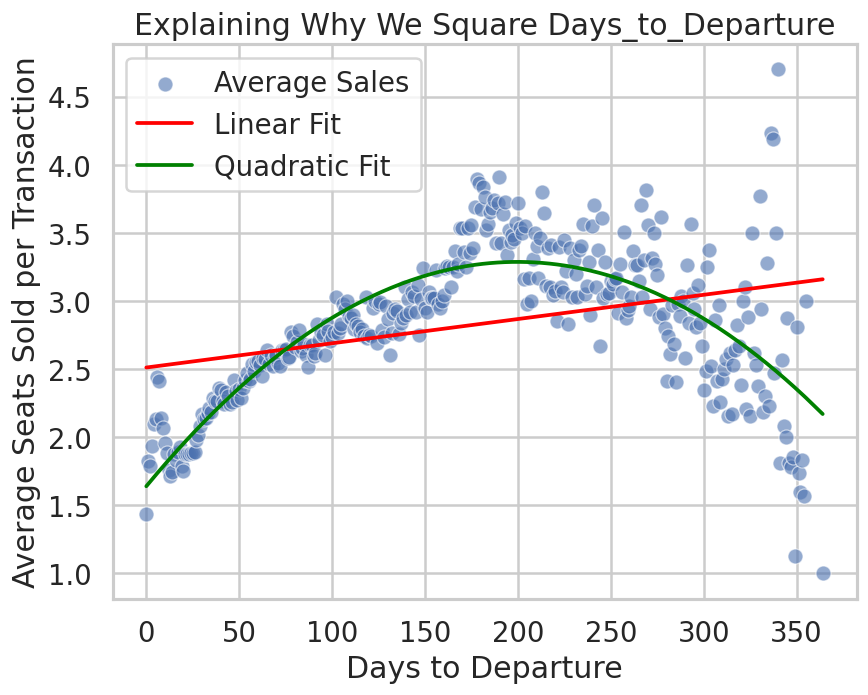

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Use the transaction-level data
df_plot = df.copy()

# Make sure we have the correct variables
df_plot['days_to_departure'] = df_plot['days_to_departure'].astype(int)
df_plot['num_seats_total'] = df_plot['num_seats_total'].astype(int)

# 1. Aggregate: average seats sold by booking horizon
avg_sales = df_plot.groupby('days_to_departure')['num_seats_total'].mean().reset_index()

X = avg_sales[['days_to_departure']].values
y = avg_sales['num_seats_total'].values

# 2. Linear regression
lin_model = LinearRegression().fit(X, y)
y_lin_pred = lin_model.predict(X)

# 3. Quadratic regression
X_quad = np.column_stack((X, X**2))
quad_model = LinearRegression().fit(X_quad, y)
y_quad_pred = quad_model.predict(X_quad)

# 4. Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x='days_to_departure', y='num_seats_total', data=avg_sales, label="Average Sales", alpha=0.6)
plt.plot(avg_sales['days_to_departure'], y_lin_pred, color="red", label="Linear Fit")
plt.plot(avg_sales['days_to_departure'], y_quad_pred, color="green", label="Quadratic Fit")
plt.xlabel("Days to Departure")
plt.ylabel("Average Seats Sold per Transaction")
plt.title("Explaining Why We Square Days_to_Departure")
plt.legend()
plt.show()

In [3]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson, NegativeBinomial

# 1. Filter dataset: only early bookings (reduce yield management bias)
df_early = df[df['days_to_departure'] > 14].copy()

# 2. Create log-transformed vars
df_early['log_price'] = np.log(df_early['mean_net_ticket_price'])
df_early['log_num_seats_total'] = np.log(df_early['num_seats_total'] + 1)

# 3. Create time controls
df_early['month'] = df_early['Dept_Date'].dt.month
df_early['dayofweek'] = df_early['Dept_Date'].dt.dayofweek

# 4. Model formula
formula = """
log_num_seats_total ~ log_price
+ days_to_departure + I(days_to_departure**2)
+ isNormCabin + isReturn + isOneway
+ C(Customer_Cat) + C(month) + C(dayofweek)
"""

# 5. OLS (log-log)
ols_model_early = smf.ols(formula=formula, data=df_early).fit(cov_type="HC3")

# 6. Poisson
pois_model_early = smf.glm(
    formula="num_seats_total ~ log_price + days_to_departure + I(days_to_departure**2) "
            "+ isNormCabin + isReturn + isOneway "
            "+ C(Customer_Cat) + C(month) + C(dayofweek)",
    data=df_early,
    family=Poisson()
).fit(cov_type="HC3")

# 7. Negative Binomial
nb_model_early = smf.glm(
    formula="num_seats_total ~ log_price + days_to_departure + I(days_to_departure**2) "
            "+ isNormCabin + isReturn + isOneway "
            "+ C(Customer_Cat) + C(month) + C(dayofweek)",
    data=df_early,
    family=NegativeBinomial()
).fit(cov_type="HC3")

# 8. Collect elasticities
elasticity_table = pd.DataFrame({
    "Model": ["OLS (log-log)", "Poisson", "Negative Binomial"],
    "Elasticity (coef)": [
        ols_model_early.params.get("log_price", None),
        pois_model_early.params.get("log_price", None),
        nb_model_early.params.get("log_price", None)
    ],
    "Std. Error": [
        ols_model_early.bse.get("log_price", None),
        pois_model_early.bse.get("log_price", None),
        nb_model_early.bse.get("log_price", None)
    ],
    "p-value": [
        ols_model_early.pvalues.get("log_price", None),
        pois_model_early.pvalues.get("log_price", None),
        nb_model_early.pvalues.get("log_price", None)
    ]
})

# Round nicely
elasticity_table = elasticity_table.round(4)

# Show table
print(elasticity_table)

# Save for report
elasticity_table.to_csv("/mnt/data/elasticity_table_earlybookings.csv", index=False)

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


               Model  Elasticity (coef)  Std. Error  p-value
0      OLS (log-log)            -0.2466      0.0032      0.0
1            Poisson            -0.4089      0.0062      0.0
2  Negative Binomial            -0.3913      0.0060      0.0
